# 타이타닉 생존자 예측

이 kernel은 ' https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy ' 을 참고하여 필사 및 변형 하였습니다.

## 목차
* 1. 문제인식
* 2. 데이터 정비  
    * 2-1 변수설명  
    * 2-2 4가지 Data Cleaning  
    * 2-3 Train_Test_Split
* 3. EDA with statistics  
    * 3-1 다양한 그래프를 이용하여 변수들과 Survived의 관계파악
* 4. Model Data  
    * 4-1. 우리만의 Tree 모형 만들어보기  
    * 4-2. CV를 이용한 모델 수행 및 Hyper-Parameter Tuning  
        * 4-2-1. Decision Tree를 바탕으로 한 Hyper-Parameter Tuning
        * 4-2-2. Feature선택을 바탕으로한 모델 Tuning
* 5. 검증 및 구현

## 1. 문제 인식
* RMS 타이타닉호는 역사상 악명 높은 난파선 중 하나이며 1912년 4월 15일 타이타닉호는 빙산과 충돌한 후 침몰하여 2224명 중 1502명이 사망했다.
* 난파선이 이런 인명피해를 낸 이유 중 하나는 구명보트가 부족했기 때문이었다. 침몰에서 살아남는데 행운의 요소가 어느 정도 포함되었지만 여성, 아동, 상ㄹ류층 등 다른 집단보다 생존 가능성이 더 높은 집단이 있었다.
* 이번 challenge에서는 어떤 종류 혹은 집단의 사람들이 살아남을 것 같았는지 부석을 하는 것이다. 특히 이 참사에서 살아남은 승객이 누구인지 예측하기 위해서 Machine Learning을 사용하여 예측해보도록 한다.
* **이번 문제는 생존을 했는지 안했는지를 예측하는 문제로 binary classification문제롤 접근하였다.**

**Note :** 이번 challenge는 Kaggle에서 주어지는 꽤나 깔끔한 데이터를 사용하였으며 감사하게도 Data architecture, governance, and extraction과 같은 처리는 해주지 않았으며 Data cleaning 위주로 진행하였다.

In [1]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import IPython
import sklearn
import matplotlib

import random
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble,\
 discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8

## 2. 데이터 준비

### 2-1. 변수설명
* 먼저, 이름을 통해 데이터를 파악하고 데이터에 대하여 자세히 알아보도록 한다. (예를 들어, 데이터의 타입이 어떻게 생겼는지 혹은 독립형 변수인지 의존형 변수인지를 알아본다.)

1. Survived : 생존한 것이 1, 생존하지 못한 것이 0, 이진 데이터.
2. PassengerID : 결과에 영향을 미치지 않는 고유식별자. 분석에서 사용하지 않는다.
3. Pclass : 순서형 데이터. 사회경제적 지위를 나타내며 (1:상위, 2:중간, 3:하위)를 나타낸다.
4. Name : 명목형 변수로, 이 변수는 feature engineering을 통해 가족크기 혹은 지위에 대한 타이틀을 도출할 수 있다. 
5. Sex & Embarked : 성별과 탑승위치는 명목형 데이터로 dummy 변수로 변환시켜 사용하도록 한다.
6. Age & Fare : 나이와 요금은 연속형 양적 데이터이다.
7. SibSp & Parch: 탑승자의 형제 자매수, 부모자녀수를 나타낸다. 둘다 이산적 quantitative 데이터이다. 가족의 크기를 만들 때 사용할 수 있으며, 가변적이다.
8. Cabin : 사고가 발생했을 때 선박의 대략적인 위치를 나타낸다. Null값이 많기 때문에 사용하지 않기로 한다.

In [3]:
data_raw = pd.read_csv('../data/titanic/train.csv')
data_val = pd.read_csv('../data/titanic/test.csv')

data1 = data_raw.copy()
data_cleaner = [data1, data_val]

print(data_raw.info())
data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
211,212,1,2,"Cameron, Miss. Clear Annie",female,35.00,0,0,F.C.C. 13528,21.0000,NaN,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.00,1,5,347077,31.3875,NaN,S
241,242,1,3,"Murphy, Miss. Katherine ""Kate""",female,NaN,1,0,367230,15.5000,NaN,Q
218,219,1,1,"Bazzani, Miss. Albina",female,32.00,0,0,11813,76.2917,D15,C
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.00,4,2,347082,31.2750,NaN,S
728,729,0,2,"Bryhl, Mr. Kurt Arnold Gottfrid",male,25.00,1,0,236853,26.0000,NaN,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0,0,113572,80.0000,B28,NaN
675,676,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18.00,0,0,349912,7.7750,NaN,S


### 2-2. 4가지 Data Cleaning : Correcting, Completing, Creating, Converting

* **Correcting** : 이상치 및 특이치 수정. **데이터 검토**를 통해 잘못된 데이터나 허용되지 않는 데이터가 있는지 확인(현재 데이터에서는 없는 것으로 나타난다.) 수정의 경우 분명히 나이나 요금처럼 특이치를 가질 것으로 보이는 column이 있지만 성급히 수정하지 않고 EDA를 하고나서 확인한 후 수정하도록 한다.
* **Completing** : Missing 정보 완성. 보통 Missing Value를 채우는 것으로써는 **삭제** 혹은 **합리적인 입력값 입력**이 있다. **(질적데이터 : mode, 정량데이터 : mean 혹은 mid 혹은 mean + 표준편차)** 일단은 기본적은 방법으로 결측값을 채우도록 한다. 물론 더 복잡한 방법이 있지만 기본적인 방법으로 결측값을 채운 후에 분석을 진행한 후 정확도를 높이기 위해서 수정하도록 한다.
* **Creating** : 새로운 feature 만들기. 기존 feature를 사용하여 새로운 feature를 만든다.
* **Converting** : 데이터 정리. 현 데이터는 범주형 데이터로 되어있어 수학적 계산하기 어렵기 때문에 dummy변수로 변환하여 계산을 해주도록 한다.

In [4]:
print('Train columns with null values : \n',
      data1.isnull().sum())
print('-'*40)

print('Test/Validation columns with null values : \n',
      data_val.isnull().sum())
print('-'*40)

data_raw.describe(include = 'all')

Train columns with null values : 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------
Test/Validation columns with null values : 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------------------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Van Impe, Mr. Jean Baptiste",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


#### Completing : 결측치 처리
* Age : 중앙값으로 처리
* Embarked : 최빈값으로 처리
* Fare : 중앙값으로 처리
* Cabin & Ticket : drop 처리

In [5]:
data1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
for dataset in data_cleaner :
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
drop_column = ['PassengerId', 'Cabin', 'Ticket']
data1.drop(drop_column, axis = 1, inplace = True)
    
print(data1.isnull().sum())
print('-'*40)
print(data_val.isnull().sum())                    

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


#### Creating : 새로운 변수 만들기 
* FamilySize : '형제자매수 + 부모자녀수 + 나'로 계산하여 가족의 크기를 게산한다.
* IsAlone : 가족수가 1명이면 1 아니면 0으로 표현한다.
* Title : 'Name'변수로 부터 ['Mr', 'Mrs', 'Miss']와 같은 title을 가져와 새로운 변수로 만들어준다.
    * Title의 경우 10개보다 적은 Title은 Misc로 통일시켜준다.
* FareBin : 'Fare'변수를 4분위수로 나뉘어 4분할된 값을 새로운 변수로 가진다.
* AgeBin : 'Age'변수를 5분위로 나뉘어 5분할된 값을 새로운 변수로 가진다.

In [7]:
data1['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [8]:
for dataset in data_cleaner :
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    
    dataset['Title'] = dataset['Name'].str.split(", ", expand = True)[1].str.split('.', expand = True)[0]
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    

title_names = (data1['Title'].value_counts() < 10)
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print('-'*40)

data1.info()
data_val.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null objec

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
461,0,3,"Morley, Mr. William",male,34.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"
695,0,2,"Chapman, Mr. Charles Henry",male,52.0,0,0,13.5000,S,1,1,Mr,"(7.91, 14.454]","(48.0, 64.0]"
771,0,3,"Jensen, Mr. Niels Peder",male,48.0,0,0,7.8542,S,1,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
700,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,227.5250,C,2,0,Mrs,"(31.0, 512.329]","(16.0, 32.0]"
675,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18.0,0,0,7.7750,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
123,1,2,"Webber, Miss. Susan",female,32.5,0,0,13.0000,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
650,0,3,"Mitkoff, Mr. Mito",male,28.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
484,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,91.0792,C,2,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"
526,1,2,"Ridsdale, Miss. Lucy",female,50.0,0,0,10.5000,S,1,1,Miss,"(7.91, 14.454]","(48.0, 64.0]"
505,0,1,"Penasco y Castellana, Mr. Victor de Satode",male,18.0,1,0,108.9000,C,2,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"


#### Converting : 원핫인코딩을 이용한 dummy변수로 변환
* Sex, Embarked, Title, AgeBin, FareBIn을 dummy변수로 변환한다.
* data1_x는 원래의 데이터를 가져온다.
* data1_x_calc는 원래데이터(성별과 Embarked는 labeling된 채로 가져온다.
* data1_x_bin은 연속형 데이터를 feature engineering한 데이터이다.
* data1_dummy는 원래데이터에서 주어진 column명에 대하여 one-hot encoding한 데이터이다.

In [9]:
label = LabelEncoder()

for dataset in data_cleaner :
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
Target = ['Survived']

data1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp',
           'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code',
                'SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x
print('Original X Y: ', data1_xy, '\n')

data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code',
               'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')

data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [10]:
print('Train columns with null values : \n', data1.isnull().sum())
print('-' *40)
print(data1.info())
print('-'* 40)

print('Test/Valdiation columns with null values : \n', data_val.isnull().sum())
print('-' * 40)
print(data_val.info())
print('-' * 40)

data_raw.describe(include = 'all')

Train columns with null values : 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareB

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Van Impe, Mr. Jean Baptiste",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### 2-3. Train_Test_Split : 75/25의 비율로 train 데이터를 분할하여 검증해보도록 하자.
* 100%로 검증할 시 TrainSet에만 Overfit 할 수 있으므로 분할한다.
* 모르는 testset에도 일반화할 수 있도록 분할하는 것이다.
* 이후에 sklearn 패키지의 교차검증을 사용해보도록 하자.

In [11]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split( data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train_y_bin, test_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train_y_dummy, test_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

print('Data1 Shape : {}'.format(data1.shape))
print('Train1 Shape : {}'.format(train1_x.shape))
print('Test1 Shape : {}'.format(test1_x.shape))

train1_x_bin.head()

Data1 Shape : (891, 19)
Train1 Shape : (668, 8)
Test1 Shape : (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


## 3. EDA with statistics

변수를 설명하고 요약할 수 있는 기술 통계와 그래프로 데이터를 탐색해 보도록 하자. feature 분류와 변수간의 상관관계를 파악할 수 있다.

In [12]:
for x in data1_x :
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by: ', x)
        print(data1[[x, Target[0]]].groupby(x, as_index = False).mean())
        print('-'*40, '\n')

print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------------------------------- 

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------------------------------- 

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------------------------------- 

Survival Correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------------------------------------- 

Survival Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------------------------------------- 

Survival Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000


### 3-1. 다양한 그래프를 이용하여 변수들과 Survived의 관계파악

#### Fare, Age, FamilySize와 Survived와의 관계 Plotting

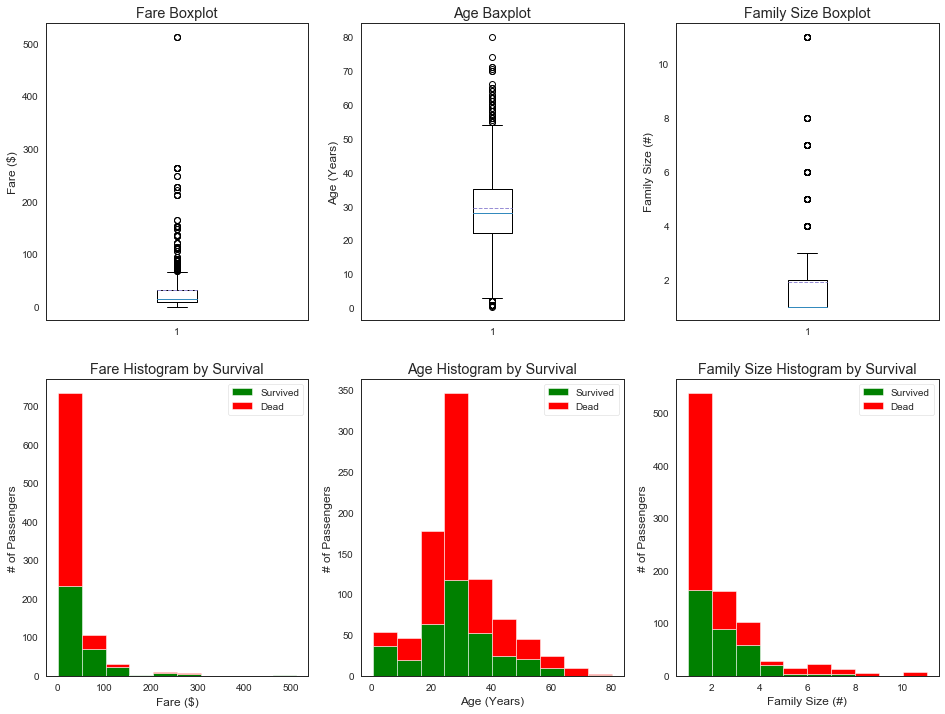

In [13]:
plt.figure(figsize = [16, 12])

plt.subplot(231)
plt.boxplot(x = data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Baxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived'] == 1]['Fare'],
              data1[data1['Survived'] == 0]['Fare']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived'] == 1]['Age'],
              data1[data1['Survived'] == 0]['Age']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived'] == 1]['FamilySize'],
              data1[data1['Survived'] == 0]['FamilySize']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

#### Embarked, IsAlone, FareBin과 Survived의 관계 Plotting

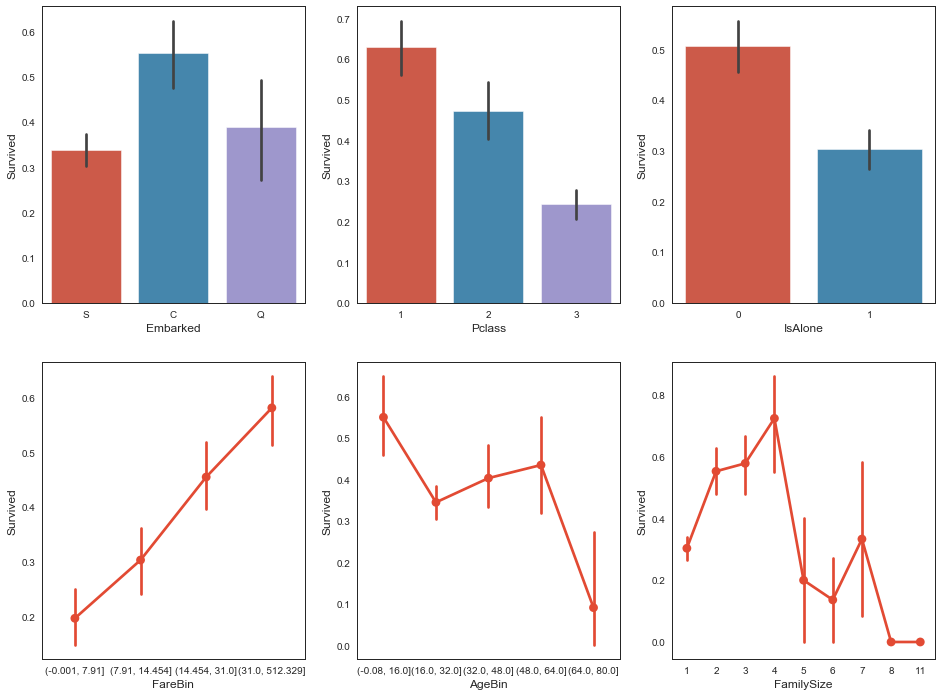

In [14]:
fig, saxis = plt.subplots(2, 3, figsize = (16, 12))

sns.barplot(x = 'Embarked', y = 'Survived',
            data = data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived',
            data = data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived',
            data = data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived', 
              data = data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',
              data = data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived',
              data = data1, ax = saxis[1,2])

#### Pclass와 Fare, Age, FamilySize사이의 관계파악

Text(0.5, 1.0, 'Pclass vs FamilySize Survival Comparison')

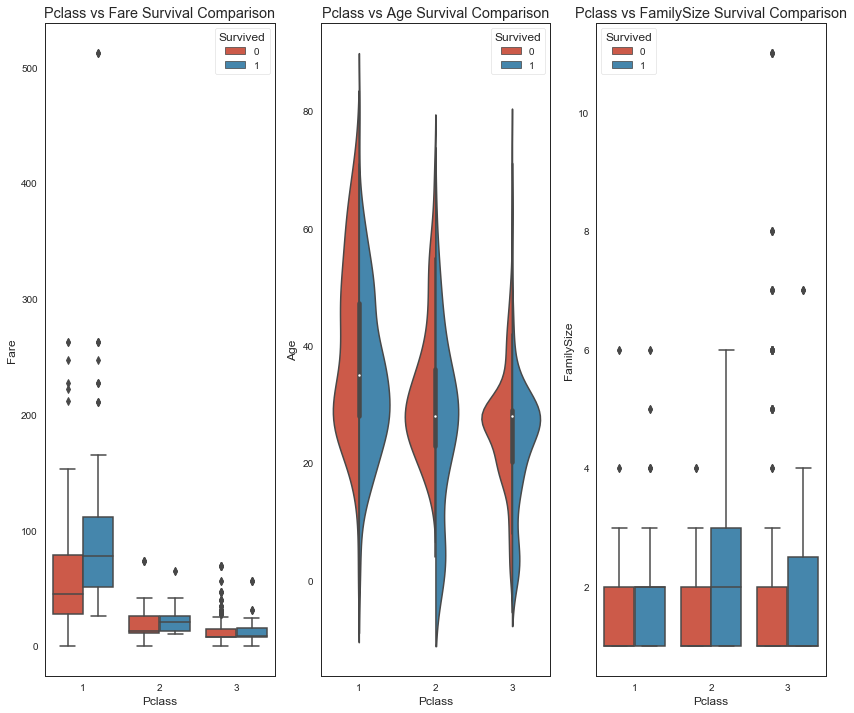

In [15]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (14, 12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived',
            data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived',
            data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y = 'FamilySize', hue = 'Survived',
            data = data1, ax =  axis3)
axis3.set_title('Pclass vs FamilySize Survival Comparison')


#### Sex와 Survival의 관계에서 Embarked, Pclass, IsAlone별로 나타내기

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

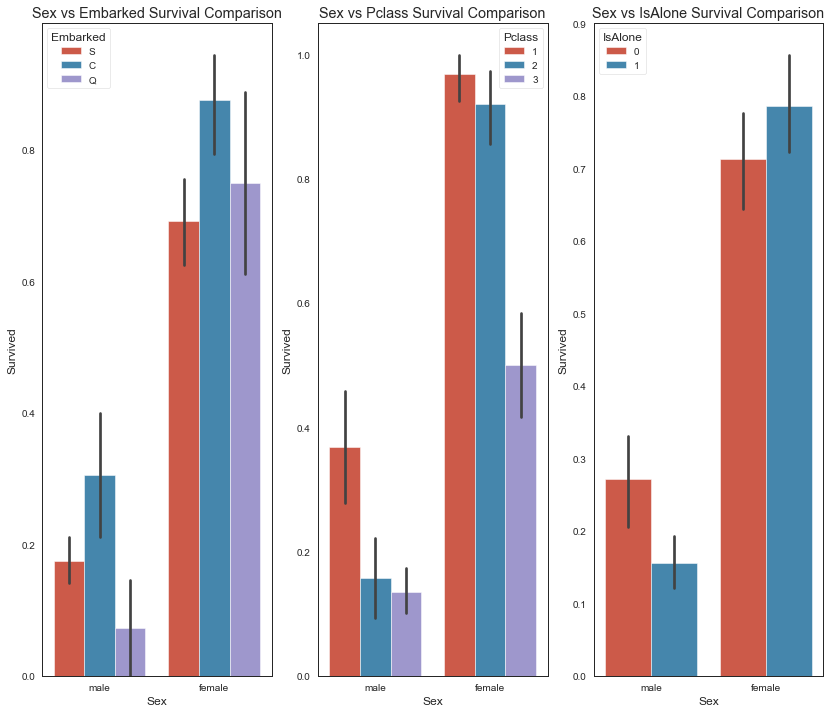

In [16]:
fig, qaxis = plt.subplots(1, 3, figsize = (14, 12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked',
            data = data1, ax = qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass',
            data = data1, ax= qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone',
            data =data1, ax = qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comparison')

#### Familysize, Pclass와 Survived사이의 관계에서 성별별로 나타내기

Text(0.5, 1.0, 'Pclass vs Sex Survived Comparison')

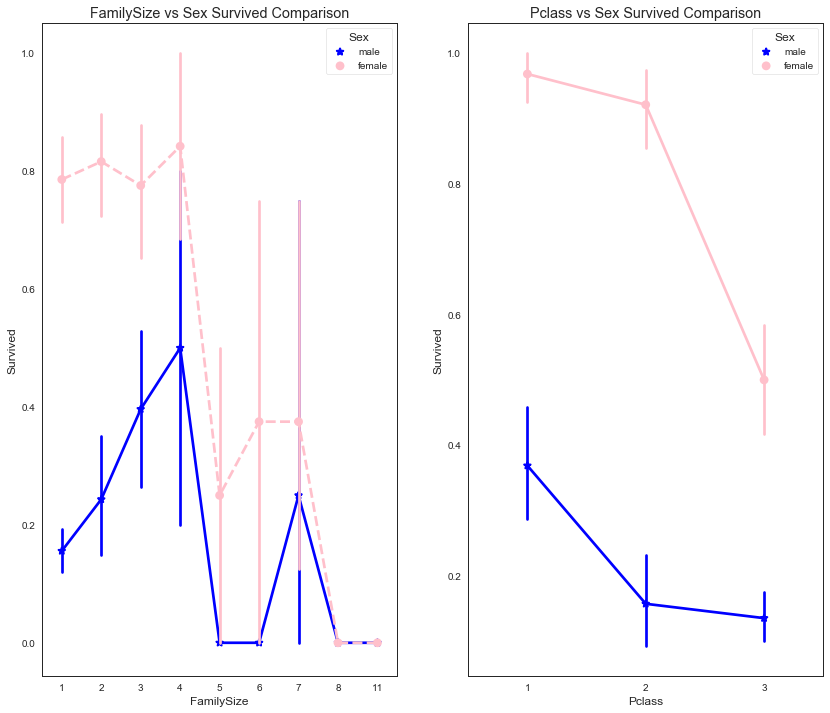

In [17]:
fig, (maxis1, maxis2) = plt.subplots(1, 2, figsize = (14, 12))

sns.pointplot(x = 'FamilySize', y = 'Survived', hue = 'Sex',
              data = data1, palette = {'male' : 'blue', 'female' : 'pink'},
              markers = ['*', 'o'], linestyles = ['-', '--'], ax = maxis1)
maxis1.set_title('FamilySize vs Sex Survived Comparison')

sns.pointplot(x = 'Pclass', y = 'Survived', hue = 'Sex',
              data = data1, palette = {'male' : 'blue', 'female' : 'pink'},
              markers = ['*', 'o'], linesytles = ['-', '--'], ax = maxis2)
maxis2.set_title('Pclass vs Sex Survived Comparison')

#### Embarked와 Pclass사이의 관계를 성별별로 나타내기

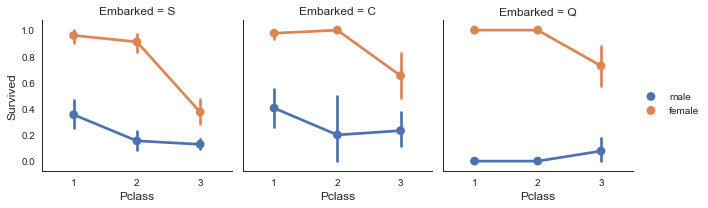

In [18]:
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', 
      ci = 95.0, palette = 'deep', hue_order = ['male', 'female'])
e.add_legend()

#### 나이별 생존자를 kdeplot으로 나타내기

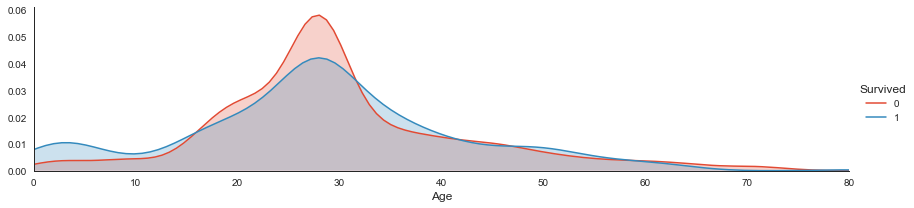

In [19]:
a = sns.FacetGrid(data1, hue = 'Survived', aspect = 4)
a.map(sns.kdeplot, 'Age', shade = True)
a.set(xlim = (0, data1['Age'].max()))
a.add_legend()

#### Sex, Pclass, Age별 생존자 비교

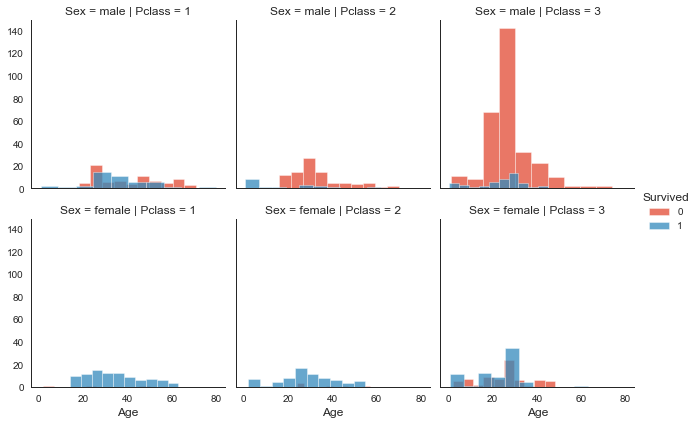

In [20]:
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

#### 전체 데이터셋에 대한 Pair Plot

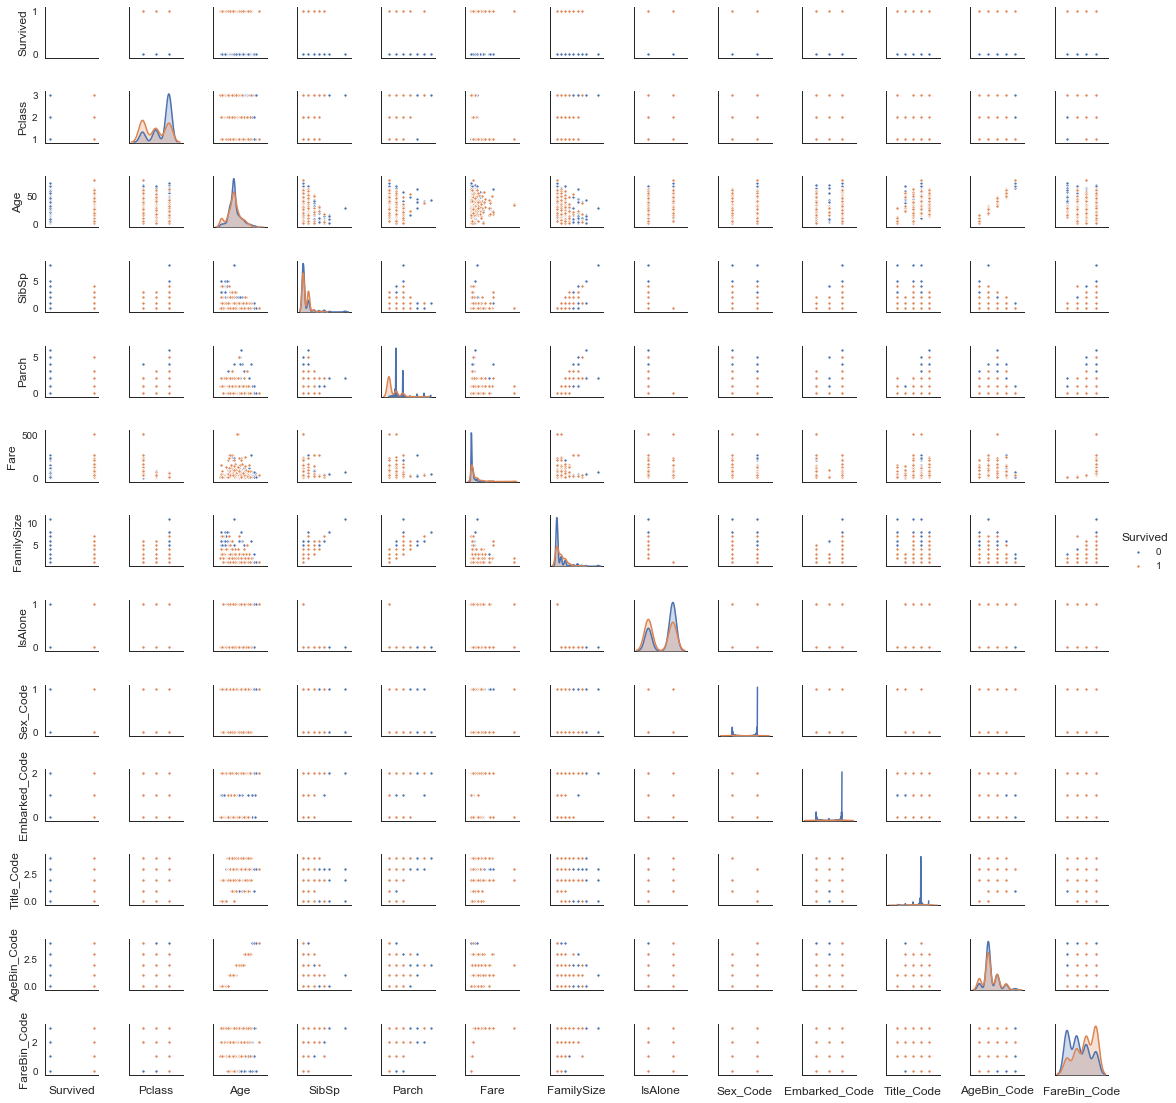

In [21]:
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep',
                  size = 1.2, diag_kind= 'kde', diag_kws = dict(shade = True),
                  plot_kws = dict(s = 10))
pp.set(xticklabels = [])

#### 데이터셋의 상관관계를 Heatmap으로 보기

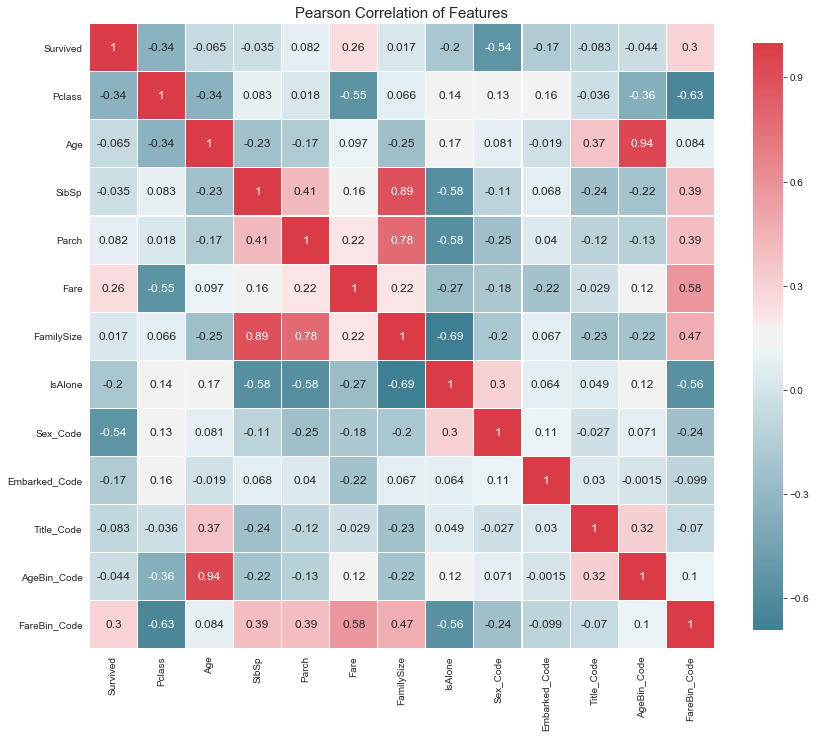

In [22]:
def correlation_heatmap(df) :
    _ , ax = plt.subplots(figsize = (14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square = True,
        cbar_kws = {'shrink' : .9},
        ax = ax,
        annot = True,
        linewidths = 0.1, vmax = 1.0, linecolor = 'white',
        annot_kws = {'fontsize' : 12}
    )
    
    plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
    
    
correlation_heatmap(data1)

## 4. Model Data

* ML의 경우 감독(지도)학습( 정답이 포함된 데이터를 학습 ), 비지도학습( 정답이 없이 데이터를 학습 ), 강화학습( 앞 두가지를 혼합시킨 것, 일련의 사건 후에 정답을 준다. )

* ML Algorithm은 4가지 범주로 축소할 수 있는데 분류, 회귀, 클러스터링, 차원 감소가 있다. 여기에서는 회귀와 분류에 초점을 맞추도록 한다.(연속 변수의 경우 회귀 알고리즘이, 이산 변수의 경우 분류 알고리즘이 필요하다.)

* 생존자를 예측하는 것은 분류문제이므로 분류알고리즘을 사용하여 문제를 해결해 나가도록 하자.

**Note :** ML Algorithm 선택방법

* MLA의 경우 모든 데이터 셋에 대하여 가장 적합한 알고리즘은 없으므로 여러개의 MLA를 시도한 후 가장 적절한 것을 선택하는 것이 가장 좋다.  
* 그렇다고 무작정 시작하는 것보다는 처음에는 Trees, Bagging, Random Forests, and Boosting으로 시작하는 것이 보다 좋다. 위의 언급한 MLA들은 서로 다른 의사결정 도구이며 처음에 시도하기 좋은 알고리즘이다.  
* 여기서는 여러 MLA들을 시도해보며, 튜닝의 경우는 Decision Tree와 이로부터 파생된 모델링 학습에 초점을 맞춰 정확도를 높이도록 할 것이다.

In [23]:
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    gaussian_process.GaussianProcessClassifier(),
    
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability = True),
    svm.NuSVC(probability = True),
    svm.LinearSVC(),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    XGBClassifier()
]

cv_split = model_selection.ShuffleSplit(n_splits = 10,
                                        test_size = .3, train_size = .6,
                                        random_state = 0)

MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean',
               'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

MLA_predict = data1[Target]

row_index = 0
for alg in MLA :
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin],
                                                data1[Target], cv = cv_split, return_train_score = True)
    
    MLA_compare.loc[row_index, 'MLA TIme'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index += 1
    

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,MLA TIme
15,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.835206,0.827612,0.0409157,NaN,0.117152
22,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.890449,0.826493,0.0617704,NaN,0.147159
16,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.834082,0.826119,0.0456629,NaN,0.123503
3,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.895131,0.824627,0.0585952,NaN,0.452341
5,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.895131,0.823134,0.0577768,NaN,0.497306
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.895131,0.822761,0.0603336,NaN,0.362396
18,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.822388,0.0625665,NaN,0.034384
4,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.866667,0.822015,0.0529916,NaN,0.394184
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.891011,0.817164,0.0512975,NaN,0.029478
14,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,NaN,0.030860


Text(0, 0.5, 'Algorithm')

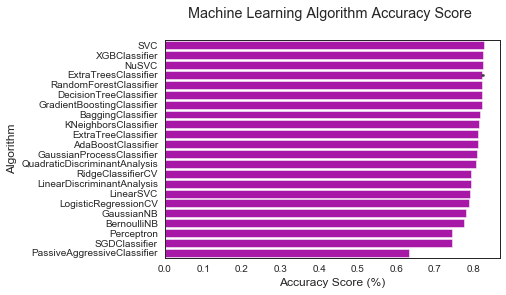

In [24]:
sns.barplot(x = 'MLA Test Accuracy Mean', y = 'MLA Name',
            data = MLA_compare, color = 'm')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

### 4-1. 우리만의 Tree 모형 만들어보기

위의 결과는 몇줄 타이핑한 것 치고는 꽤나 괜찮은 결과물이다.
투자 수익이 아주 좋은 결과물이라고 할 수 있으며 앞으로 튜닝을 하는데 있어서 투자 수익은 아주 중요한 키워드이다. 정확도를 0.1프로를 높이기 위해서 1달을 투자하는 것은 아마도 좋은 일 일수도 있지만안좋은 일일 확률이 훨씬 높다. 이 점을 잊지않으며 파라미터 튜닝을 진행하도록 하자.

**Note :** **먼저 기준 정확도를 정해야한다.**   
우리는 2224명 중 1502명이 죽었다는 것을 알고 있으며 67.5%에 해당한다. 그러므로 우리가 100% 사망을 예측한다고 할 때 사망률은 67.5%가 옳은 값일 것이다. 그러므로 68% 이상이 나오는 것은 불량 모델 성능으로 설정하도록 하자.

**Note : 자신만의 모델을 만들자**  
여기서는 우리가 우리들만의 tree model을 직접 만들어볼 것이다. Decision Tree를 직접 구현할 떄는 target을 나눌 수 있는 몇몇 질문들을 해서 구현할 수 있다. 각 질문에 대하여 50%가 넘으면 1을 50%보다 낮으면 0을 입력하여 의사결정을 하도록 한다.

* 질문 1  : 타이타닉호에 있었나요?
* 질문 2  : 너는 남자니 여자니?
* 질문 3A : 너는 클래스 1,2,3 중 어디에 있었니?
* 질문 4A : 너는 Embarked의 C,Q,S 중 어디에 있었니?  
* 위와 같이 질문을 나열하도록 한다.


위와 같이 질문을 트리형식으로 내려가서 의사결정을 하는 것이 Decision Tree의 기본구조이다. 코딩을 하는데 있어서 이렇게까지 할 필요는 없지만 Decision Tree의 구조를 제대로 파악하기 위해서 직접 질문으로부터 파생된 Decision Tree를 코딩으로 구현해 보도록 하자.

In [25]:
for index, row in data1.iterrows() :
    if random.random() > .5 :
        data1.set_value(index, 'Random_Predict', 1)
        
    else :
        data1.set_value(index, 'Random_Predict', 0)
        

data1['Random_Score'] = 0
data1.loc[(data1['Survived'] == data1['Random_Predict']), 'Random_Score'] = 1
print('Coin Flip Model Accuracy: {:.2f}%'.format(data1['Random_Score'].mean()*100))
      
print('Coin Flip Model Accuracy w/SciKit: {:.2f}%'.format(metrics.accuracy_score(data1['Survived'], data1['Random_Predict'])*100))

Coin Flip Model Accuracy: 50.17%
Coin Flip Model Accuracy w/SciKit: 50.17%


In [26]:
pivot_female = data1[data1.Sex == 'female'].groupby(['Sex', 'Pclass', 'Embarked', 'FareBin'])['Survived'].mean()
print('Survival Decision Tree w/Female Node: \n', pivot_female)

pivot_male = data1[data1.Sex == 'male'].groupby(['Sex', 'Title'])['Survived'].mean()
print('\n\nSurvival Decision Tree w/Male Node: \n', pivot_male)

Survival Decision Tree w/Female Node: 
 Sex     Pclass  Embarked  FareBin        
female  1       C         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]          NaN
                          (31.0, 512.329]    1.000000
                S         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (-0.001, 7.91]          NaN
                          (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (-0.001, 7.91]          NaN


In [27]:
def mytree(df) :
    
    Model = pd.DataFrame(data = {'Predict' : []})
    male_title = ['Master']
    
    for index, row in df.iterrows() :
        
        # Question 1 : Were you on Titanic
        Model.loc[index, 'Predict'] = 0
        
        # Question 2 : Are you female
        if (df.loc[index, 'Sex'] == 'female') :
            Model.loc[index, 'Predict'] = 1
            
        # Question 5B Female = FareBin
        if ((df.loc[index, 'Sex'] == 'female') &
            (df.loc[index, 'Pclass'] == 3) &
            (df.loc[index, 'Embarked'] == 'S') &
            (df.loc[index, 'Fare'] > 8)) :
            Model.loc[index, 'Predict'] = 0
            
        # Question 3B Male : Title
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)) :
            Model.loc[index, 'Predict'] = 1
            
    return Model

Tree_Predict = mytree(data1)
print('Decision Tree MOdel Accuracy/Precision Score: {:.2f}% \n'.\
      format(metrics.accuracy_score(data1['Survived'], Tree_Predict)*100))

print(metrics.classification_report(data1['Survived'], Tree_Predict))

Decision Tree MOdel Accuracy/Precision Score: 82.04% 

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       549
           1       0.82      0.68      0.75       342

    accuracy                           0.82       891
   macro avg       0.82      0.79      0.80       891
weighted avg       0.82      0.82      0.82       891



#### 그래프에 Plotting하여 정확도 요약하기
* Confusion Matrix 계산하기
* Non-Normalized Confusion Matrix Plotting하기
* Normalized Confusion Matrix Plotting하기

Confusion matrix, without normalization
[[497  52]
 [108 234]]


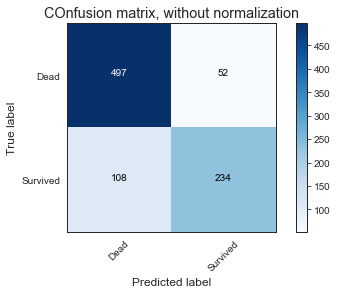

In [28]:
import itertools
def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = 'Confusion matrix',
                         cmap = plt.cm.Blues) :
    
    if normalize :
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Normalized confusion matrix')
        
    else :
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        
cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_Predict)
np.set_printoptions(precision = 2)
        
class_names = ['Dead', 'Survived']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names,
                      title = 'COnfusion matrix, without normalization')

### 4-2. CV를 이용한 모델 수행 및 Hyper-Parameter Tuning

* **Cross Validation Set** : 우리의 모델을 평가하기 위해서 우리는 CV Set을 이용해야하며 보통 CV Set을 사용하는 이유는 Train Set에 오버핏 되는 것을 방지하기 위해서 사용한다. 

#### 4-2-1. Decision Tree를 바탕으로 한 Hyper-Parameter Tuning

* **DT의 장점** :
    * 해석 및 이해가 쉽다. Tree들을 시각화할 수 있다.
    * DT의 경우 Data 정리를 많이 요구하지 않는다.(다만 DT의 경우 missing value에 대한 처리를 자동으로 해주진 않기 때문에 이는 참고해야한다.)
    * 수치형 데이터 그리고 범주형 데이터 모두 사용할 수 있다.
    * Multi-Output문제에도 적용할 수 있다.
    * White-Box 모델로서 논리를 더 쉽게 이해하고 설명할 수 있다.
    * 통계적 방법으로 모델을 검증할 수 있고, 이를 바탕으로 신뢰성을 설명할 수 있다.
    * 데이터의 실제 모델에 가정된 사항이 조금 위반되더라도 우수한 성능을 발휘한다.
    
    
* **DT의 단점** :
    * Overfitting이 될 수 있다. 즉, 지나치게 복잡한 트리구조가 만들어 질 수 있다.(샘플의 최소 개수 설정, 트리의 최대 깊이 설정과 같은 방법으로 Overfit을 방지해야 한다.)
    * DT의 경우 데이터의 작은 변화로 인해 완전히 다른 Tree 구조가 될 수 있으므로 불안정할 수 있다.
    * XOR, parity, multiplexer 문제 등 DT가 쉽게 표현하지 않아 배우기 어려운 개념들이 있다.
    * 데이터가 편향되어 있다면 편향된 Tree 구조가 만들어지기 쉽다. 그러므로 데이터가 편향되지 않도록 만들어줄 필요성이 있다.
    
 
* **DT API의 기본구조** :
    * class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
    * `ParameterGrid`, `GridSearchCV`를 사용하여 모델을 튜닝할 것이며 `ROC_AUC`에 맞춰서 점수화 할 것이다. 그리고 이후에 Tree를 시각화 해서 나타내보도록 한다.

In [29]:
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score = True)
dtree.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score = True)
tune_model.fit(data1[data1_x_bin], data1[Target])


print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))


BEFORE DT Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.35
AFTER DT Test w/bin score mean: 87.40
AFTER DT Test w/bin score 3*std: +/- 5.00


In [30]:
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin],
                                             data1[Target], cv = cv_split, return_train_score = True)
dtree.fit(data1[data1_x_bin], data1[Target])

print('Before DT Parameters : ', dtree.get_params())
print('Before DT Training w/bin score mean: {:.2f}'.format(base_results['train_score'].mean()*100))
print('Before DT Test w/bin score mean : {:.2f}'.format(base_results['test_score'].mean()*100))
print('Before DT Test w/bin score 3*std: +/- {:.2f}'.format(base_results['test_score'].std()*100*3))
print('-'*40)

param_grid = {'criterion' : ['gini', 'entropy'],
              #'splitter' : ['best', 'random'],
              'max_depth' : [2, 4, 6, 8, 10, None],
              #'min_samples_split' : [2, 5, 10, .03, .05],
              #'min_samples_leaf' : [1, 5, 10, .03, .05],
              #'max_features' : [None, 'auto'],
              'random_state' : [0]}

#print(list(model_selection.ParameterGrid(param_grid)))

tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score = True)
tune_model.fit(data1[data1_x_bin], data1[Target])


print('After DT Parameters: ', tune_model.best_params_)
print('After DT Training w/bin score mean: {:.2f}'. format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print('After DT Test w/bin score mean: {:.2f}'. format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('After DT Test w/bin score 3*std: +/- {:.2f}'. format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*40)



Before DT Parameters :  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 0, 'splitter': 'best'}
Before DT Training w/bin score mean: 89.51
Before DT Test w/bin score mean : 82.09
Before DT Test w/bin score 3*std: +/- 5.57
----------------------------------------
After DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
After DT Training w/bin score mean: 89.35
After DT Test w/bin score mean: 87.40
After DT Test w/bin score 3*std: +/- 5.00
----------------------------------------


#### 4-2-2. Feature선택을 바탕으로한 모델 Tuning
* Feature를 더 늘린다고 해서 Model이 더 좋아지는 것이 아니라 올바른 Feature가 더 좋은 Model을 만드는 것이다. 즉, Model의 성능을 높이기 위해서는 Feature를 선택하는 것이라고 할 수 있다.
* Scikit Learn 패키지에 몇 가지 옵션이 있고 CV와 함께 RFE(reculsive feature elimination)을 사용할 것이다.

In [31]:
print('Before DT RFE Training Shape Old: ', data1[data1_x_bin].shape)
print('Before DT RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print('Before DT RFE Training w/bin score mean: {:.2f}'.format(base_results['train_score'].mean()*100))
print('Before DT RFE Test w/bin score mean: {:.2f}'.format(base_results['test_score'].mean()*100))
print('Before DT RFE Test w/bin score 3*std: +/- {:.2f}'.format(base_results['test_score'].std()*100*3))
print('-'*40)

dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy',
                                    cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe],
                                             data1[Target], cv = cv_split,
                                             return_train_score = True)

print('After DT RFE Training Shape New: ', data1[X_rfe].shape)
print('After DT RFE Training Columns New: ', X_rfe)
print('After DT RFE Training w/bin score mean: {:.2f}'.format(rfe_results['test_score'].mean()*100))
print('After DT RFE Test w/bin score mean: {:.2f}'.format(rfe_results['test_score'].mean()*100))
print('After DT RFE Test w/bin score 3*std: +/- {:.2f}'.format(rfe_results['test_score'].std()*100*3))
print('-'*40)

rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),
                                              param_grid = param_grid,
                                              scoring = 'roc_auc',
                                              cv = cv_split,
                                              return_train_score = True)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

print('After DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
print('After DT RFE Tuned Training w/bin score mean: {:.2f}'.format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print('After DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}'.format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*40)

Before DT RFE Training Shape Old:  (891, 7)
Before DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
Before DT RFE Training w/bin score mean: 89.51
Before DT RFE Test w/bin score mean: 82.09
Before DT RFE Test w/bin score 3*std: +/- 5.57
----------------------------------------
After DT RFE Training Shape New:  (891, 6)
After DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
After DT RFE Training w/bin score mean: 83.06
After DT RFE Test w/bin score mean: 83.06
After DT RFE Test w/bin score 3*std: +/- 6.22
----------------------------------------
After DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
After DT RFE Tuned Training w/bin score mean: 89.39
After DT RFE Tuned Test w/bin score 3*std: +/- 6.21
----------------------------------------


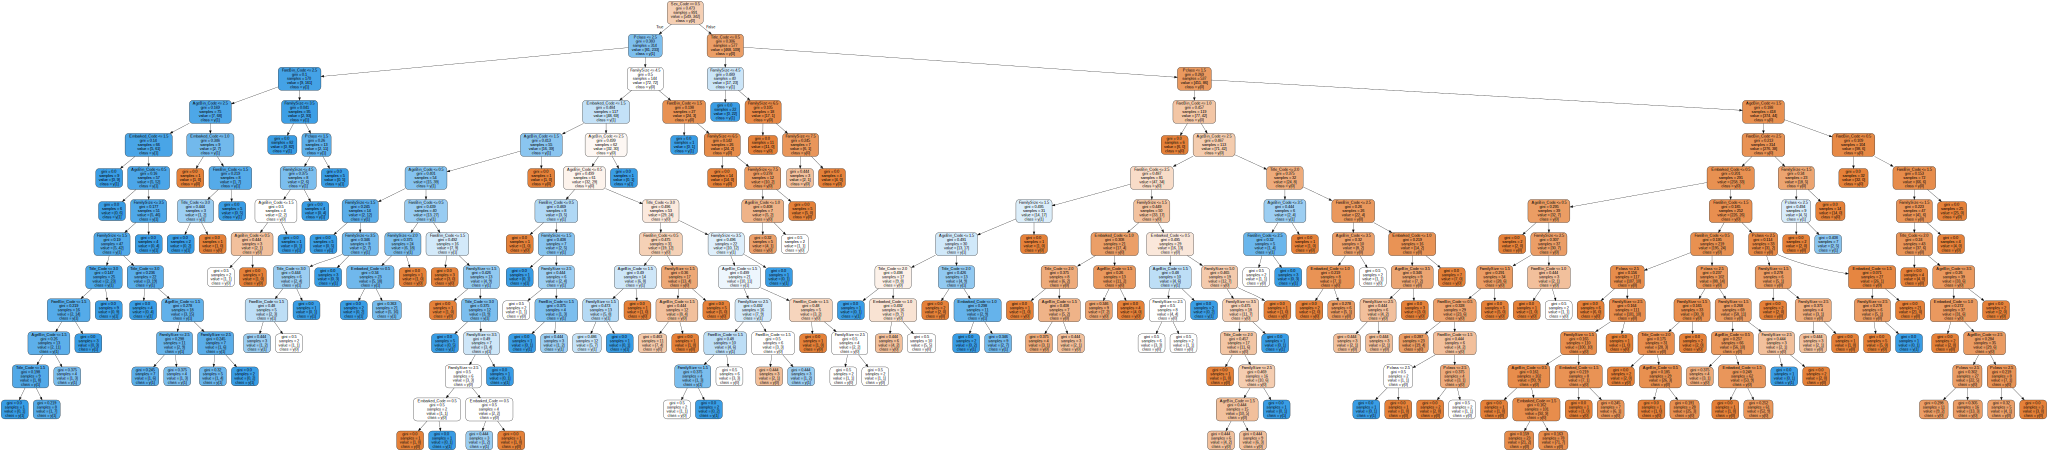

In [32]:
import graphviz
dot_data = tree.export_graphviz(dtree, out_file = None,
                               feature_names = data1_x_bin, class_names = True,
                               filled = True, rounded = True)
graph = graphviz.Source(dot_data)
graph

## 5. 검증 및 구현
validation set을 이요하여 제출을 준비하도록 하자.

* 다음 히트맵을 보고 다음과 같은 정보를 알 수 있다.
    * 1이면 정확히 일치하며 0이면 정확히 반대이다.
    * 어느 정도의 상관을 가진 변수들을 가지고 그들을 결합함으로써 강한 알고리즘을 만들 수 있다(여기서는 옅은 빨간색, 그리고 파란색)
  

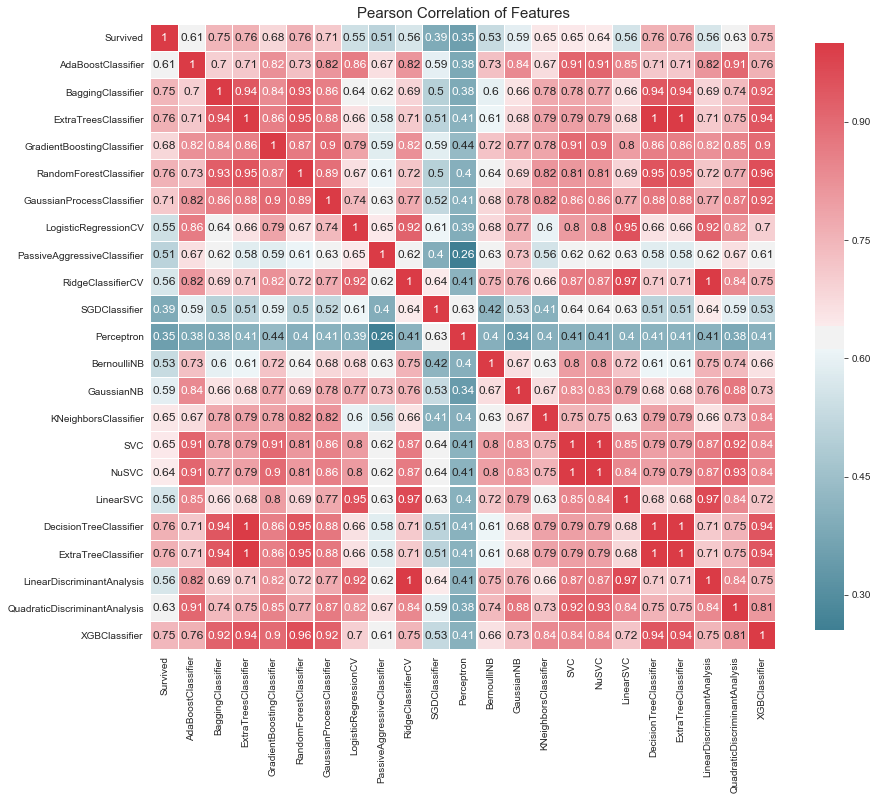

In [33]:
correlation_heatmap(MLA_predict)

In [38]:
vote_est = [
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
    
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    ('lr', linear_model.LogisticRegressionCV()),
    
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    ('knn', neighbors.KNeighborsClassifier()),
    
    ('svc', svm.SVC(probability = True)),
    
    ('xgb', XGBClassifier())
]

vote_hard = ensemble.VotingClassifier(estimators = vote_est, voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin],
                                              data1[Target], cv = cv_split,
                                              return_train_score = True)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print('Hard Voting Training w/bin score mean: {:.2f}'.format(vote_hard_cv['train_score'].mean()*100))
print('Hard Voting Test w/bin score mean: {:.2f}'.format(vote_hard_cv['test_score'].mean()*100))
print('Hard Voting Test w/bin score 3*std: +/- {:.2f}'.format(vote_hard_cv['test_score'].std()*100*3))
print('-'*40)

vote_soft = ensemble.VotingClassifier(estimators = vote_est, voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin],
                                              data1[Target],
                                              cv = cv_split, return_train_score = True)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print('Soft Voting Training w/bin score mean: {:.2f}'.format(vote_soft_cv['train_score'].mean()*100))
print('Soft Voting Test w/bin score meann: {:.2f}'.format(vote_soft_cv['test_score'].mean()*100))
print('Soft Voting Test w/bin score 3*std: +/- {:.2f}'.format(vote_soft_cv['test_score'].std()*100*3))
print('-'*40)

Hard Voting Training w/bin score mean: 87.25
Hard Voting Test w/bin score mean: 82.13
Hard Voting Test w/bin score 3*std: +/- 4.43
----------------------------------------
Soft Voting Training w/bin score mean: 87.81
Soft Voting Test w/bin score meann: 82.57
Soft Voting Test w/bin score 3*std: +/- 4.78
----------------------------------------


In [46]:
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_param = [
    [{
        'n_estimators' : grid_n_estimator,
        'learning_rate' : grid_learn,
        'random_state' : grid_seed
    }],
    
    [{
        'n_estimators' : grid_n_estimator,
        'max_samples' : grid_ratio,
        'random_state' : grid_seed
    }],
    
    [{
        'n_estimators' : grid_n_estimator,
        'criterion' : grid_criterion,
        'max_depth' : grid_max_depth,
        'random_state' : grid_seed
    }],
    
    [{
        'learning_rate' : [.05],
        'n_estimators' : [300],
        'max_depth' : grid_max_depth,
        'random_state' : grid_seed
    }],
    
    [{
        'n_estimators' : grid_n_estimator,
        'criterion' : grid_criterion,
        'max_depth' : grid_max_depth,
        'oob_score' : [True],
        'random_state' : grid_seed
    }],
    
    [{
        'max_iter_predict' : grid_n_estimator,
        'random_state' : grid_seed
    }],
    
    [{
        'fit_intercept' : grid_bool,
        'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'random_state' : grid_seed
    }],
    
    [{
        'alpha' : grid_ratio,
    }],
    
    [{}],
    
    [{
        'n_neighbors' : [1,2,3,4,5,6,7],
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
    }],
    
    [{
        'C' : [1,2,3,4,5],
        'gamma' : grid_ratio,
        'decision_function_shape' : ['ovo', 'ovr'],
        'probability' : [True],
        'random_state' : grid_seed
    }],
    
    [{
        'learning_rate' : grid_learn,
        'max_depth' : [1,2,4,6,8,10],
        'n_estimators' : grid_n_estimator,
        'seed' : grid_seed
    }]
]

start_total = time.perf_counter()

for clf, param in zip(vote_est, grid_param) :
    start = time.perf_counter()
    best_search = model_selection.GridSearchCV(estimator = clf[1],
                                               param_grid = param,
                                               cv = cv_split,
                                               scoring = 'roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target])
    run = time.perf_counter() - start
    
    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param)
    

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*40)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 157.92 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 142.29 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 259.89 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 202.57 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 315.22 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 13.61 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'rando

In [48]:
grid_hard = ensemble.VotingClassifier(estimators = vote_est,
                                      voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard,
                                              data1[data1_x_bin],
                                              data1[Target],
                                              cv = cv_split,
                                              return_train_score = True)
grid_hard.fit(data1[data1_x_bin], data1[Target])

print('Hard Voting w/Tuned Hyperparmeters Training w/bin score mean: {:.2f}'.\
      format(grid_hard_cv['train_score'].mean()*100))
print('Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}'.\
      format(grid_hard_cv['test_score'].mean()*100))
print('Hard Voting w/Tuned Hyperpameters Test w/bin score*3std: +/- {:.2f}'.\
      format(grid_hard_cv['test_score'].std()*100*3))
print('-'*40)

grid_soft = ensemble.VotingClassifier(estimators = vote_est,
                                     voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft,
                                              data1[data1_x_bin],
                                              data1[Target],
                                              cv = cv_split,
                                              return_train_score = True)
grid_soft.fit(data1[data1_x_bin], data1[Target])

print('Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}'.\
      format(grid_soft_cv['train_score'].mean()*100))
print('Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}'.\
      format(grid_soft_cv['test_score'].mean()*100))
print('Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}'.\
      format(grid_soft_cv['test_score'].std()*100*3))
print('-'*40)

Hard Voting w/Tuned Hyperparmeters Training w/bin score mean: 85.28
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.35
Hard Voting w/Tuned Hyperpameters Test w/bin score*3std: +/- 5.30
----------------------------------------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 84.83
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 82.16
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.50
----------------------------------------


In [49]:
print(data_val.info())
print('-'*40)

data_val['Survived'] = mytree(data_val).astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
FamilySize       418 non-null int64
IsAlone          418 non-null int64
Title            418 non-null object
FareBin          418 non-null category
AgeBin           418 non-null category
Sex_Code         418 non-null int32
Embarked_Code    418 non-null int32
Title_Code       418 non-null int32
AgeBin_Code      418 non-null int32
FareBin_Code     418 non-null int32
dtypes: category(2), float64(2), int32(5), int64(6), object(6)
memory usage: 55.3+ KB
None
---------------------------------